In this lab, we will try to process data in Farming Season first.

The order of provinces are: Ha_Noi, Hai_Duong, Hung_Yen, Thai_Binh, Ha_Nam, Nam_Dinh, Ninh_Binh


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [231]:
#season must be initialized by either 'Farming Season' or 'Winter-Spring'
season = 'Winter-Spring'

In [232]:
df = pd.DataFrame()

if (season == 'Farming Season'):
    df = pd.read_csv('CropYield(Farming Season).csv')
else:
    df = pd.read_csv('CropYield(Winter-Spring).csv')

df.head()

,Year,Province,Productivity
0,2000,Ha_Noi,53.158379
1,2001,Ha_Noi,53.471074
2,2002,Ha_Noi,55.402405
3,2003,Ha_Noi,56.389149
4,2004,Ha_Noi,58.386473


In [233]:
provinces = ['Ha_Noi', 'Hai_Duong', 'Hung_Yen', 'Nam_Dinh', 'Ninh_Binh', 'Thai_Binh', 'Ha_Nam']
colors = ['blue', 'orange', 'olive', 'cyan', 'gray', 'pink', 'brown']

Model built on Training Set in order to determine which degree leads to best MSE on Testing Set

In [234]:
def linear_regression(X_train, y_train, X_test, y_test):
    linear_model = LinearRegression().fit(X_train, y_train)

    MSE_test = mean_squared_error(y_test, linear_model.predict(X_test))

    del linear_model

    return MSE_test

In [235]:
def best_degree(X, y):

    ans = 0

    best_mse = 99999999
    
    for degree in range(1, 20):

        poly = PolynomialFeatures(degree=degree, include_bias=False)

        X_poly = poly.fit_transform(X)

        del poly

        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.6, random_state=1)

        MSE_test = linear_regression(X_train, y_train, X_test, y_test)

        if (MSE_test < best_mse):
            ans = degree
            best_mse = MSE_test
    
    return ans

For each province, finding the best corresponding degree

In [236]:
degrees = []

for province in provinces:

    X = np.arange(0, 21).reshape(-1, 1)

    y = df.loc[df['Province'] == province]['Productivity']

    degrees.append(best_degree(X, y))
    

After considering & evaluating carefully through 3 ways of splitting data: 75:25, 60:40, 50:50 , its turn out that:

- for Farming Season, the best degrees for corresponding provinces in this order is:
[3, 4, 4, 1, 2, 4, 4]

- For Winter-Spring, 

In [237]:
if (season == 'Farming Season'):
    degrees.clear
    degrees = [3, 4, 4, 1, 2, 4, 4]
else:
    degrees.clear
    degrees = [1, 1, 1, 1, 2, 1, 3]

After determining crop yield trend, this data is utilized for the purpose of evaluating random crop yield which is affected by weather factors. Then, we will store it in a dataframe and export into a csv file.

In [238]:
table = pd.DataFrame()

cols = ['Year', 'Province', 'RandomCropYield']

for i, col in enumerate(cols):
    table.insert(i, col, None)

In [239]:
def export(province, random_yield):
    
    for year in range(2000, 2021):
        row = [year, province]

        row.append(random_yield[year - 2000])

        table.loc[len(table)] = row

Train_Test_Split is utilized in determining the best corresponding degree for each province. Then, a new model built on entire dataset rather than a part, and its data degree is best degree which we found out previously. They are for evaluating yield trend.

In [240]:
def yield_trend(degree, province):
    X = np.arange(0, 21).reshape(-1, 1)

    y = df.loc[df['Province'] == province]['Productivity']

    X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X)

    linear_model = LinearRegression().fit(X_poly, y)

    y_predicted = linear_model.predict(X_poly)

    export(province=province, random_yield=list(y - y_predicted))

    return (y_predicted, linear_model.coef_, linear_model.intercept_)

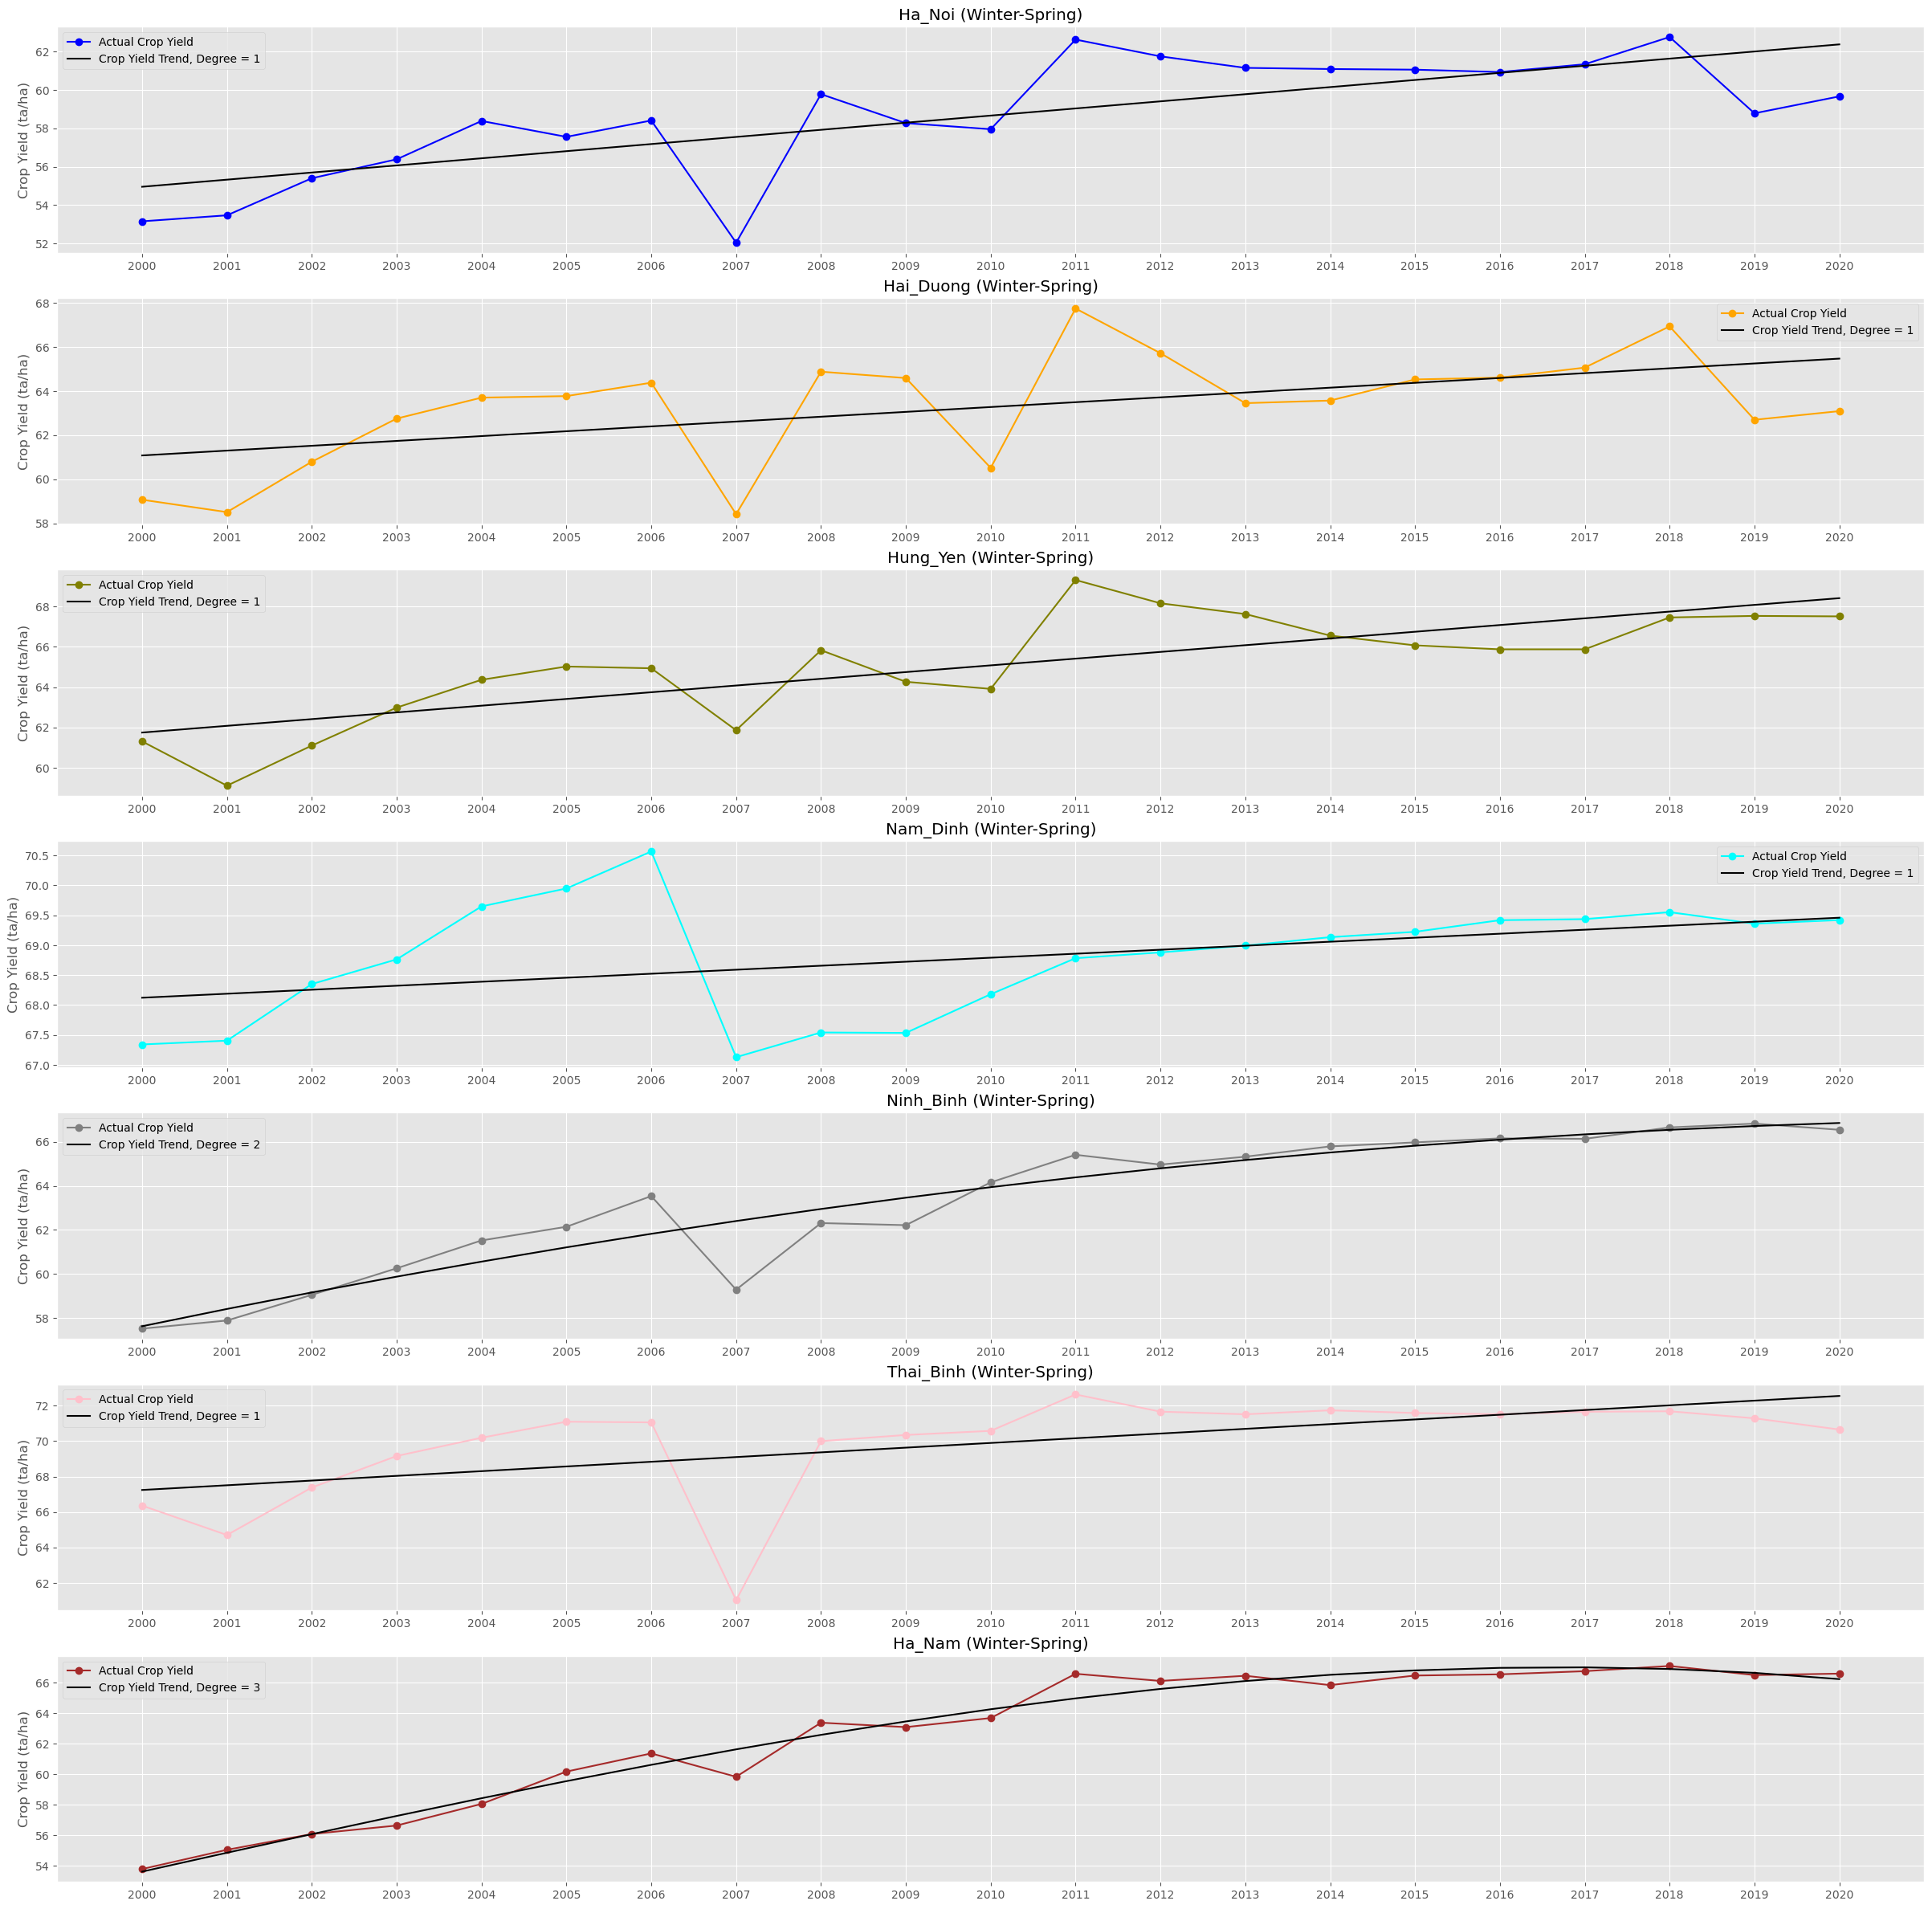

In [241]:
coefs = []
intercepts = []

nrows = 7
ncols = 1

plt.style.use('ggplot') 

fig = plt.figure(figsize=(30, 30))

for id, province in enumerate(provinces):
    
    crop_yield_trend, coef, intercept = yield_trend(degree=degrees[id], province=province)

    #Collect coefficients & intercepts
    coefs.append(coef)
    intercepts.append(intercept)

    #Plotting crop yield trend, and comparing with actual crop yield
    actual_crop_yield = df.loc[df['Province'] == province]['Productivity']

    ax = fig.add_subplot(nrows, ncols, id + 1)
    ax.plot(np.arange(2000, 2021), actual_crop_yield, marker='o', c=colors[id], label='Actual Crop Yield')
    ax.plot(np.arange(2000, 2021), crop_yield_trend, c='black', label='Crop Yield Trend, Degree = ' + str(degrees[id]))

    ax.legend()
    ax.set_xticks(np.arange(2000, 2021, dtype=int), list(map(str, list(np.arange(2000, 2021)))))
    ax.set_title(province + " (" + season + ")")

    # ax.set_xlabel('Year') 
    ax.set_ylabel('Crop Yield (ta/ha)')

    del actual_crop_yield

# plt.legend()
plt.show()


In [242]:
for i, province in enumerate(provinces):
    print(province, degrees[i], coefs[i], intercepts[i])

Ha_Noi 1 [0.37089004] 54.95834520482254
Hai_Duong 1 [0.21981801] 61.07956918960147
Hung_Yen 1 [0.33284981] 61.75336132720679
Nam_Dinh 1 [0.06685733] 68.1230861996719
Ninh_Binh 2 [ 0.8005884  -0.01698257] 57.63280220742884
Thai_Binh 1 [0.26530678] 67.24484832885719
Ha_Nam 3 [ 1.24451664 -0.00530666 -0.0012681 ] 53.6087374215593


In [243]:
if (season == 'Farming Season'):
    table.to_csv('RandomCropYield (Farming Season).csv', index=False, mode='w')
else:
    table.to_csv('RandomCropYield (Winter-Spring).csv', index=False, mode='w')
